In [1]:
import os
import shutil

import torch
import torchvision

import numpy as np

import matplotlib.pyplot as plt

import tqdm.notebook as tqdm

import time

In [2]:
BATCH_SIZE = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) #values [0-1]
fmnist_train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download= True)
fmnist_train_dataloader = torch.utils.data.DataLoader(dataset = fmnist_train_dataset,
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               drop_last = True)
fmnist_val_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download= True)
fmnist_val_dataloader = torch.utils.data.DataLoader(dataset = fmnist_val_dataset,
                                               batch_size = BATCH_SIZE,
                                               shuffle = False,
                                               drop_last = True)

100%|██████████| 26421880/26421880 [00:03<00:00, 8221775.10it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 142477.53it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2585859.02it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6568992.09it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
len(fmnist_train_dataset), len(fmnist_val_dataset)

(60000, 10000)

In [5]:
x, y = next(iter(fmnist_train_dataloader))
x.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [6]:
def plot_images(batch, display=(1, 8), idxToDsiplay=None):
    fig = plt.figure()
    # Needed to add spacing between 1st and 2nd row
    # Add a margin between the main title and sub-plots
#     fig.subplots_adjust(hspace=0.1, top=0.85)
    
#     fig, axs = plt.subplots(nrows=1, ncols=display, sharex=True,sharey=True,squeeze=True)
    rng = np.random.default_rng()
    if idxToDsiplay is None: 
        idxToDsiplay = rng.choice(batch.shape[0], size=min(batch.shape[0], display[0]*display[1]), replace=batch.shape[0]<(display[0]*display[1]))
    for i, idx in enumerate(idxToDsiplay):
        ax = fig.add_subplot(display[0], display[1], i+1)
        ax.imshow(batch[idx].permute(1, 2, 0), cmap='gray')
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
#     plt.tight_layout()
    plt.subplots_adjust(wspace=0.08, hspace=-0.65)
    plt.show()
    return idxToDsiplay
#     bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#     width, height = bbox.width, bbox.height
#     print("Axis sizes are(in pixels):", width, height)
#     if title!= None: fig.suptitle(title) 
#     plt.axis('off')
# #     fig.set_figwidth(4)
# #     fig.set_figheight(1)
#     fig.set_figwidth(height*display[1]/fig.dpi+5)
#     fig.set_figheight(width*display[0]/fig.dpi)
#     print(fig.get_size_inches()*fig.dpi) # size in pixels
#     print(fig.get_size_inches()*fig.dpi) # size in pixels
#     plt.show()
        

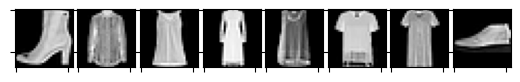

In [7]:
i = plot_images(x)

In [53]:
class VariationalAutoencoder(torch.nn.Module):
    def __init__(self, z_dims=32):
        super().__init__()
        self.encoder = torch.nn.Sequential(torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1), 
                                           torch.nn.ReLU(),
                                           torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
                                           torch.nn.ReLU(),
                                           torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7), #N,64,1,1
                                           torch.nn.Flatten() # N, 64
                                          )
        self.mean_ = torch.nn.Linear(64, z_dims)
        self.logOfVariance_ = torch.nn.Linear(64, z_dims)
        self.linear_expand = torch.nn.Linear(z_dims, 64)
        self.decoder = torch.nn.Sequential(torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=7),
                                           torch.nn.ReLU(),
                                           torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
                                           torch.nn.ReLU(),
                                           torch.nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
                                           torch.nn.Sigmoid()
                                          )
    def encode(self, x):
        encoded = self.encoder(x)
        return self.mean_(encoded), self.logOfVariance_(encoded)

    def decode(self, x):
        x = self.linear_expand(x)
        x.unsqueeze_(2)
        x.unsqueeze_(3)
        return self.decoder(x)
        
    def forward(self, x):
        mean, log_var = self.encode(x)
        std = torch.exp(0.5*log_var)  
        eps = torch.randn_like(std)
        z_sample = eps.mul(std).add_(mean)
        decoded = self.decode(z_sample)
        return decoded, mean, log_var

In [54]:
NUM_EPOCHS = 30
LR = 0.01
BASE_PATH = '/content'
model = VariationalAutoencoder()

In [55]:
out, mean, log_var = model(x)
out.shape, mean.shape, log_var.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 32]), torch.Size([64, 32]))

In [56]:
class Task():
    '''This class helps in efficiently training pytorch model easily'''
    def __init__(self, model, 
                 BASE_PATH,
                 train_dataloader, 
                 val_dataloader=None,  
                 DEVICE='cpu', 
                 lr=0.001):
        self.model = model
        self.BASE_PATH = BASE_PATH #path where the output from training will be saved
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.DEVICE = DEVICE #device type 'cuda' or 'cpu'
        self.lr = lr   # model learning rate
        self.optimizer = self.get_optimizer()
        self.scheduler = self.get_scheduler()
        self.version_dir = None
        self.history = {} # dictionary that stores loss and other metrices each epoch
    
    def get_scheduler(self):
        '''reurn a scheduler'''
        return torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', 
                                                   factor=0.8, patience=5, 
                                                   threshold=0.001, threshold_mode='rel', 
                                                   cooldown=2, min_lr=0.001, 
                                                   eps=1e-08, verbose=False)
    
    def get_loss(self, output, y, mean, log_var):
        '''write the loss function here'''
        RECON = torch.nn.functional.mse_loss(output, y, reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        return RECON + KLD, RECON, KLD
        #print(output.shape, y.shape)
        #loss = torch.nn.MSELoss()
        # return loss(output, y)
    
    def plot_images(self, X, outputs):
        '''this fuunction is called for plotting images in between trainng'''
        idxToPlot = plot_images(X.detach().cpu())
        plot_images(outputs.detach().cpu(), idxToDsiplay=idxToPlot)
    
    def get_optimizer(self):
        '''return optimizer'''
        return torch.optim.Adam(self.model.parameters(), self.lr, weight_decay=1e-5)
    
    def get_version_dir(self):
        '''this function return the new folder name for saving the output of current training run'''
        versions = [f.name for f in os.scandir(self.BASE_PATH) if f.is_dir() and f.name.startswith('Version')]
        curr_version = None
        if len(versions)==0:
            curr_version = 'Version0'
        else:
            curr_version = f'Version{int(versions[-1][7:])+1}'
        PATH = os.path.join(self.BASE_PATH, curr_version)
        if not os.path.exists(PATH):
           os.makedirs(PATH)
        print(f"The output for current run will be saved at {PATH}")
        return PATH
    
    def save_checkpoint(self, name, epoch):
        '''this function saves the checkpoint with the given parameter "name"'''
        # save model and history
        PATH = os.path.join(self.version_dir, name)
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history,
            }
        if self.scheduler:
            checkpoint['scheduler'] = self.scheduler.state_dict()
        torch.save(checkpoint, PATH)
                
    def load_checkpoint(self, PATH):
        '''this function load the checkpoint for given "PATH"'''
        checkpoint = torch.load(PATH)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.history = checkpoint['history']
        if self.scheduler:
            self.scheduler.load_state_dict(checkpoint['scheduler'])
        return checkpoint['epoch']
    
    def train(self, max_epochs=25, 
              continue_training=False, continue_path=None, 
              validate_after_k=1, #validate after k epoch
              save_after_k=-1, #save after k epoch
              plot_after_k=1): #plot imges after k epoch
        #get the directory to save output of current run
        self.version_dir = self.get_version_dir()
        
        #set the model to device
        self.model = self.model.to(self.DEVICE)
        
        best_loss = float('inf') #tracking avg validation accuracy for each epoch
        update_best = True
        
        start_epoch = 0
        # load trained model
        if continue_training:
            start_epoch = self.load_checkpoint(continue_path)
        
        for epoch in tqdm.trange(start_epoch, max_epochs):
            since = time.time()
            running_metrics = {}
            running_metrics.setdefault('train_loss', 0.0)
            running_metrics.setdefault('val_loss', 0.0)
            running_metrics.setdefault('train_kld', 0.0)
            running_metrics.setdefault('val_kld', 0.0)
#             running_metrics.setdefault('val_accuracy', 0.0)

            #Training mode
            self.model.train()
            tqdm_loader = tqdm.tqdm(self.train_dataloader)
            for batch in tqdm_loader:
                tqdm_loader.set_description(f"Training Epoch {epoch}")
                self.optimizer.zero_grad() # zero the parameter gradients
                X, Y = batch[0].to(self.DEVICE), batch[1].to(self.DEVICE)
                # track history if only in train
                with torch.set_grad_enabled(True):
                    outputs, mean, log_var = self.model(X)
                    loss, recon, kld = self.get_loss(outputs, X, mean, log_var)
                    loss.backward()
                    self.optimizer.step()
                # statistics
                running_metrics['train_loss'] += loss.item()
                running_metrics['train_kld'] += kld.item()
                tqdm_loader.set_postfix(training_loss=loss.item())

            #Validation mode
            validation_done = False
            if (self.val_dataloader != None) and ((epoch-start_epoch+1)%validate_after_k ==0):
                model.eval()
                tqdm_loader = tqdm.tqdm(self.val_dataloader)
                for batch in tqdm_loader:
                    tqdm_loader.set_description(f"Validating Epoch {epoch}")
                    X, Y = batch[0].to(DEVICE), batch[1].to(DEVICE)
                    # predict
                    outputs, mean, log_var = self.model(X)
                    loss, recon, kld = self.get_loss(outputs, X, mean, log_var)
                    # statistics
                    running_metrics['val_loss'] += loss.item()
                    running_metrics['val_kld'] += kld.item()
                    tqdm_loader.set_postfix(validation_loss=loss.item())
                # LR scheduler
                if self.scheduler is not None:
                    self.scheduler.step(running_metrics['val_loss'])
                print(f"total validation loss = {running_metrics['val_loss']}")
                validation_done = True
        
                #define how to get the best and set (update_best=True/False) based on that
                if running_metrics['val_loss'] < best_loss:
                    best_loss = running_metrics['val_loss']
                    update_best = True
                else:
                    update_best = False
                    
            #plotting after k epochs
            if ((epoch-start_epoch+1)%plot_after_k ==0):
                self.plot_images(X, outputs)
            
            # saving epoch level matrices
            for metric_name in running_metrics:
                if metric_name.startswith('val') and validation_done:
                    self.history.setdefault('val', {}).setdefault(metric_name, []).append(running_metrics[metric_name])
                else:
                    self.history.setdefault('train', {}).setdefault(metric_name, []).append(running_metrics[metric_name])
                    
            #save model
            if update_best:
                print('updating best checkpoint')
                self.save_checkpoint('best', epoch)
            if save_after_k!=-1 and (epoch+1)%save_after_k==0:
                self.save_checkpoint(f'epoch{epoch}', epoch)
            if epoch == (max_epochs-1):
                self.save_checkpoint('last', epoch)
                
            time_elapsed = time.time() - since
            self.history.setdefault('times', []).append(time_elapsed)     # save times per-epoch
            print(f"Epoch {epoch} complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s with total training loss {self.history['train']['train_loss'][-1]}")

In [60]:
variational_autoencoder_training = Task(model, 
                            BASE_PATH, 
                            fmnist_train_dataloader, 
                            fmnist_val_dataloader,
                            DEVICE=DEVICE, 
                            lr=LR)

In [59]:
# shutil.rmtree('/content/Version1')

The output for current run will be saved at /content/Version0


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 0 complete in 0m 15s with total training loss 2043524.4338378906


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 278840.9259033203
updating best checkpoint
Epoch 1 complete in 0m 17s with total training loss 1688874.9067382812


  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 2 complete in 0m 15s with total training loss 1661079.0004882812


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 272920.8903808594
updating best checkpoint
Epoch 3 complete in 0m 23s with total training loss 1650852.720703125


  0%|          | 0/937 [00:00<?, ?it/s]

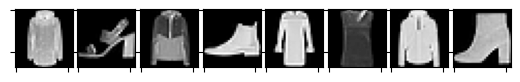

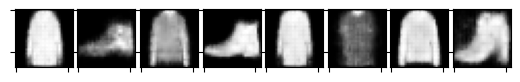

updating best checkpoint
Epoch 4 complete in 0m 20s with total training loss 1637696.0517578125


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 270724.60583496094
updating best checkpoint
Epoch 5 complete in 0m 19s with total training loss 1632774.1248779297


  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 6 complete in 0m 16s with total training loss 1630119.8387451172


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 268597.84509277344
updating best checkpoint
Epoch 7 complete in 0m 18s with total training loss 1624940.5020751953


  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 8 complete in 0m 16s with total training loss 1627930.2912597656


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 267512.64990234375


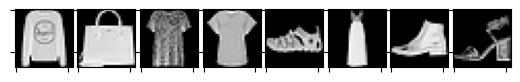

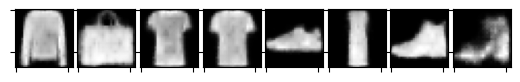

updating best checkpoint
Epoch 9 complete in 0m 19s with total training loss 1617855.9643554688


  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 10 complete in 0m 16s with total training loss 1619375.1317138672


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 270620.2783203125
Epoch 11 complete in 0m 19s with total training loss 1615996.4755859375


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 12 complete in 0m 17s with total training loss 1613497.4182128906


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 268604.44580078125
Epoch 13 complete in 0m 19s with total training loss 1610962.0421142578


  0%|          | 0/937 [00:00<?, ?it/s]

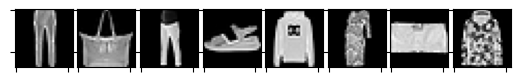

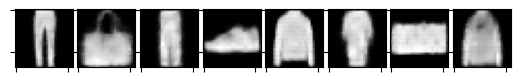

Epoch 14 complete in 0m 17s with total training loss 1604969.8865966797


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 266819.7236328125
updating best checkpoint
Epoch 15 complete in 0m 19s with total training loss 1601470.5441894531


  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 16 complete in 0m 17s with total training loss 1599449.0166015625


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 267659.24169921875
Epoch 17 complete in 0m 19s with total training loss 1598828.6315917969


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 18 complete in 0m 16s with total training loss 1594856.6026611328


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 268772.9278564453


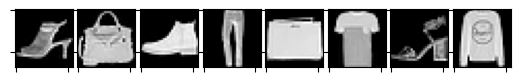

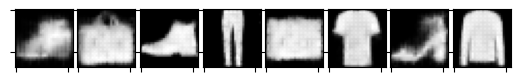

Epoch 19 complete in 0m 21s with total training loss 1592294.4165039062


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 20 complete in 0m 17s with total training loss 1590155.4080810547


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 263169.767578125
updating best checkpoint
Epoch 21 complete in 0m 20s with total training loss 1588535.808227539


  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 22 complete in 0m 17s with total training loss 1591050.734741211


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 262929.86096191406
updating best checkpoint
Epoch 23 complete in 0m 20s with total training loss 1589922.251953125


  0%|          | 0/937 [00:00<?, ?it/s]

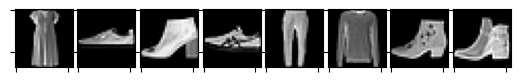

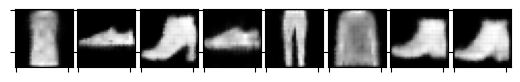

updating best checkpoint
Epoch 24 complete in 0m 19s with total training loss 1588385.0535888672


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 264508.94396972656
Epoch 25 complete in 0m 20s with total training loss 1587080.355102539


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 26 complete in 0m 18s with total training loss 1586875.6177978516


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 263010.2452392578
Epoch 27 complete in 0m 20s with total training loss 1582512.115600586


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 28 complete in 0m 17s with total training loss 1582648.5264892578


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 266888.1848144531


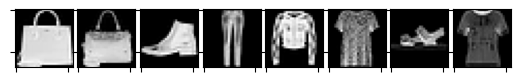

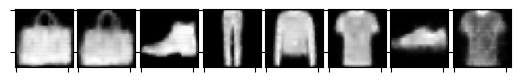

Epoch 29 complete in 0m 22s with total training loss 1582974.556640625


In [61]:
variational_autoencoder_training.train( NUM_EPOCHS, 
                            continue_training=False,
                            continue_path=None,
                            validate_after_k=2,
                            save_after_k=-1,
                            plot_after_k=5)

**analysis**

In [62]:
PATH = '/content/Version0/last'
checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
history = checkpoint['history']

In [63]:
history.keys(), print(checkpoint['epoch'])

29


(dict_keys(['train', 'times', 'val']), None)

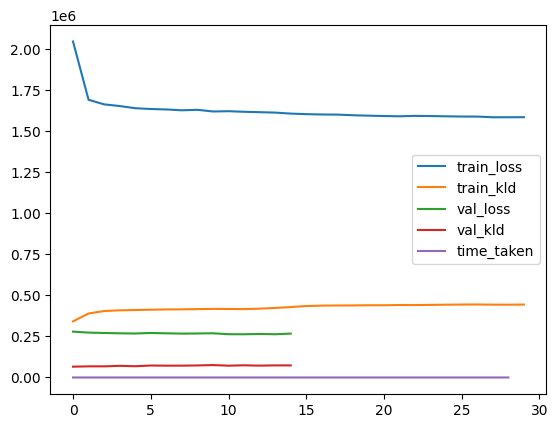

In [64]:
plt.plot(history['train']['train_loss'], label='train_loss')
plt.plot(history['train']['train_kld'], label='train_kld')
plt.plot(history['val']['val_loss'], label='val_loss')
plt.plot(history['val']['val_kld'], label='val_kld')
plt.plot(history['times'], label='time_taken')
plt.legend()

### training again with increased lr

In [65]:
NUM_EPOCHS = 40
LR = 0.1 #increased lr to check if loss decreses or not //foolish thing to do
# BASE_PATH = '/kaggle/working/'
CONT_PATH = '/content/Version0/best'

In [ ]:
# autoencoder_training = Task(model, 
#                             BASE_PATH, 
#                             fmnist_train_dataloader, 
#                             fmnist_val_dataloader,
#                             DEVICE=DEVICE, 
#                             lr=LR)

The output for current run will be saved at /content/Version1


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 24 complete in 0m 16s with total training loss 1596785.7647705078


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 267033.9797363281
updating best checkpoint
Epoch 25 complete in 0m 18s with total training loss 1584403.4324951172


  0%|          | 0/937 [00:00<?, ?it/s]

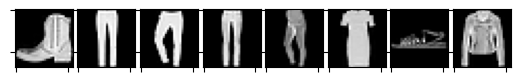

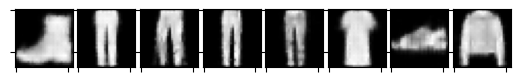

updating best checkpoint
Epoch 26 complete in 0m 17s with total training loss 1584960.9877929688


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 263808.33728027344
updating best checkpoint
Epoch 27 complete in 0m 18s with total training loss 1583489.025756836


  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 28 complete in 0m 16s with total training loss 1585469.0959472656


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 268127.86950683594


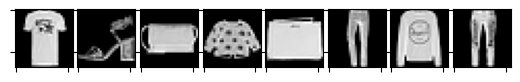

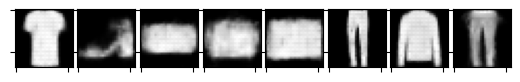

Epoch 29 complete in 0m 20s with total training loss 1583354.7624511719


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 30 complete in 0m 16s with total training loss 1590464.2602539062


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 262283.58435058594
updating best checkpoint
Epoch 31 complete in 0m 19s with total training loss 1596781.910522461


  0%|          | 0/937 [00:00<?, ?it/s]

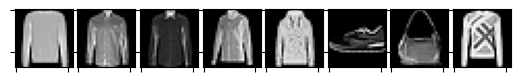

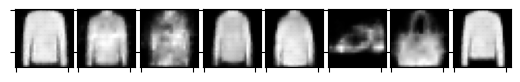

updating best checkpoint
Epoch 32 complete in 0m 17s with total training loss 1582465.7227783203


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 264187.74475097656
Epoch 33 complete in 0m 20s with total training loss 1589129.0982666016


  0%|          | 0/937 [00:00<?, ?it/s]

Epoch 34 complete in 0m 17s with total training loss 1580684.3116455078


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 260321.34313964844


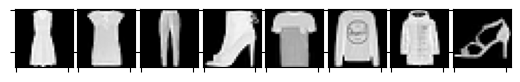

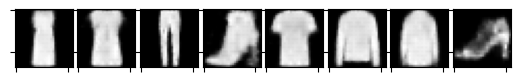

updating best checkpoint
Epoch 35 complete in 0m 20s with total training loss 1585557.5920410156


  0%|          | 0/937 [00:00<?, ?it/s]

updating best checkpoint
Epoch 36 complete in 0m 18s with total training loss 1572880.3978271484


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 262210.5505371094
Epoch 37 complete in 0m 19s with total training loss 1577236.425415039


  0%|          | 0/937 [00:00<?, ?it/s]

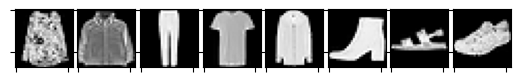

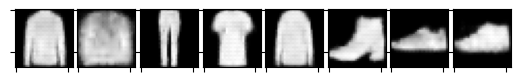

Epoch 38 complete in 0m 18s with total training loss 1579295.3083496094


  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

total validation loss = 262358.27734375
Epoch 39 complete in 0m 20s with total training loss 1577812.3468017578


In [66]:
variational_autoencoder_training.train( NUM_EPOCHS, 
                            continue_training=True,
                            continue_path=CONT_PATH,
                            validate_after_k=2,
                            save_after_k=-1,
                            plot_after_k=3)

In [68]:
PATH = '/content/Version1/last'
checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
history = checkpoint['history']
print(checkpoint['epoch'])

39


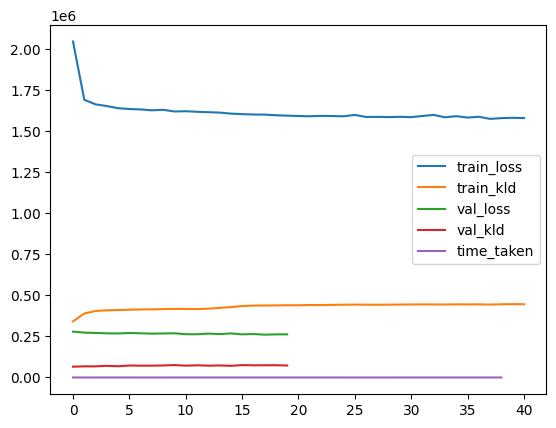

In [69]:
plt.plot(history['train']['train_loss'], label='train_loss')
plt.plot(history['train']['train_kld'], label='train_kld')
plt.plot(history['val']['val_loss'], label='val_loss')
plt.plot(history['val']['val_kld'], label='val_kld')
plt.plot(history['times'], label='time_taken')
plt.legend()

**comments**
* model losses are huge -- high contribution of reconstruction losses

* model needs trainng for lot more epochs
* may be we need to increase complexity of model - bais is high

**testing**

In [70]:
test_model = VariationalAutoencoder()

In [71]:
PATH = '/content/Version1/best'
checkpoint = torch.load(PATH)
test_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [79]:
x, y = next(iter(fmnist_val_dataloader))
output, *_ = test_model(x)
output = output.detach().cpu()
x.shape, output.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 1, 28, 28]))

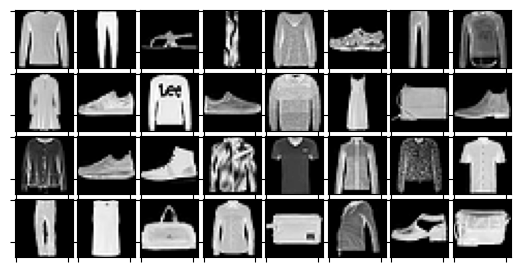

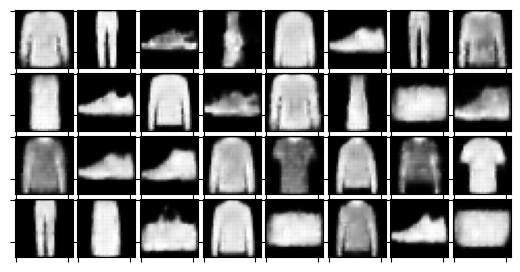

array([55, 41, 52, 32, 49, 21, 24, 16, 29, 22,  1, 12, 20, 13, 18,  0, 25,
       61, 43, 17, 59, 57, 51, 40, 47, 27, 62, 26, 58, 48, 23, 56])

In [80]:
i = plot_images(x, (4, 8))
plot_images(output, (4, 8), i)